In [7]:
# execute this part to modify the css style
from IPython.core.display import HTML
def css_styling():
    styles = open("data/custom3.css").read()
    return HTML(styles)
css_styling()

Pour eviter d'avoir un jupyter trop chargé de code, nous avons écrit des fichiers python à l'extérieure.

# Model Training

In this section we will train multiple types of classifiers and decide which classifier will be more effective in detecting default. Before we have to split our data into training and testing sets and separate the features from the labels.

In [21]:
import warnings
warnings.filterwarnings("ignore")

from Models.model_training import * 
from Models.model_tuning import * 
from FeaturesEngineering.preprocessing import *
from utils.sampling import *
from utils.util import *
from FeaturesEngineering.encoding import *

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import pandas_profiling as pp
from imblearn.under_sampling import RandomUnderSampler


df = prepocess_data("data/raw/CreditTraining.csv")

#encode data
cat = [col for col in df if df[col].dtype.name == 'category'] + ['is_closed_date']
dict_encod = {"WOEEncoder": cat}
encoder = encoding(dict_encod)
encoder.fit(df,df.Y)
df = encoder.transform(df)

X = df.drop("Y", axis=1)
y = df.Y
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

Memory usage of dataframe is 0.82 MB
Memory usage after optimization is: 0.18 MB
Decreased by 78.6%


We select multiple classifier to 

In [22]:
clf_list = ["LogisticRegression",
            "XGBClassifier",
            "RandomForestClassifier", 
            "MLPClassifier",
            "AdaBoostClassifier",
            "LGBMClassifier",
            "KNeighborsClassifier",
            "SVC",
            "GaussianProcessClassifier",
            "DecisionTreeClassifier",
           ]

classifiers = get_models(clf_list, 
                         X_train, 
                         y_train,
                         sampling_method=RandomUnderSampler(sampling_strategy='majority')
                        )

In [3]:
classifiers, result = train_models(classifiers=classifiers, X=X_train, y=y_train)
print(result)

0/10 : Training LogisticRegression .... [OK]
1/10 : Training XGBClassifier .... [OK]
2/10 : Training RandomForestClassifier .... [OK]
3/10 : Training MLPClassifier .... [OK]
4/10 : Training AdaBoostClassifier .... [OK]
5/10 : Training LGBMClassifier .... [OK]
6/10 : Training KNeighborsClassifier .... [OK]
7/10 : Training SVC .... [OK]
8/10 : Training GaussianProcessClassifier .... [OK]
9/10 : Training DecisionTreeClassifier .... [OK]
                    clf_name        pr        rc        f1       auc       acc
0         LogisticRegression  0.385034  0.901274  0.539561  0.893924  0.887648
1              XGBClassifier  0.387016  0.987261  0.556054  0.932025  0.884857
2     RandomForestClassifier  0.347722  0.923567  0.505226  0.893527  0.867876
3              MLPClassifier  0.389444  0.869427  0.537931  0.881012  0.890905
4         AdaBoostClassifier  0.391363  0.923567  0.549763  0.905196  0.889509
5             LGBMClassifier  0.307364  0.917197  0.460432  0.877168  0.842987
6       K

Precision as the name says, says how precise (how sure) is our model in detecting default while recall is the amount of default cases our model is able to detect.

**Precision/Recall Tradeoff:** The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect, so there will be more false positive.

**F1 score** is needed when you want to seek a balance between Precision and Recall.

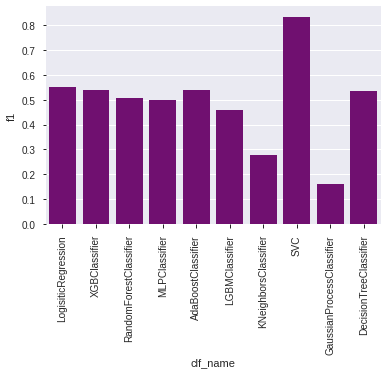

In [4]:
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

The training result show that SVC is better at prediction. Let's go deeper and do cross validation to see if it does not overfit the training data.

### Learning Curves:
- The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)

<module 'matplotlib.pyplot' from '/home/kanva/deep3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

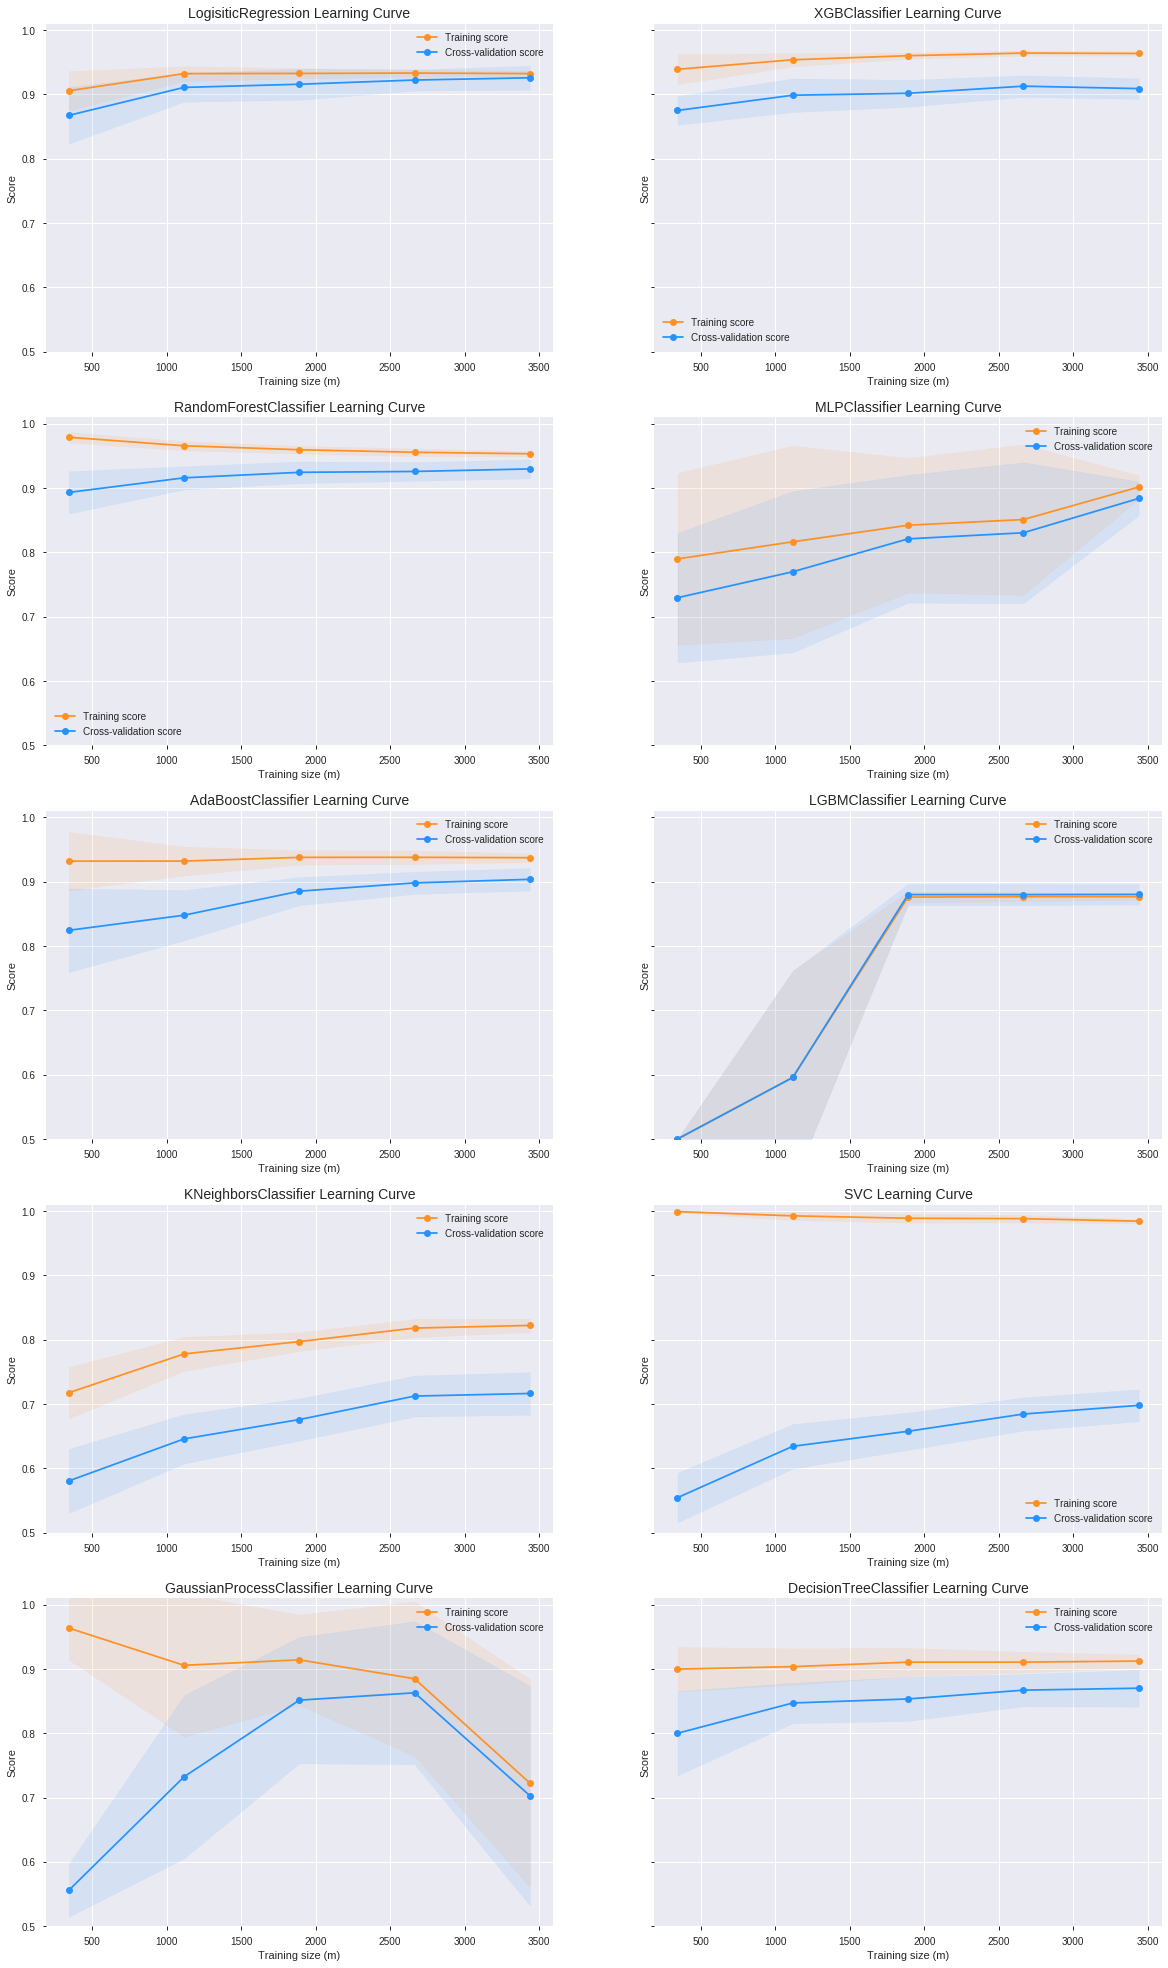

In [5]:
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42, )
plot_learning_curve(classifiers, X_train, y_train, (0.5, 1.01), cv=cv, n_jobs=-1)

The cross validation result show that SVC and KNeighborsClassifier overfit the data. 


### Test Set

                    clf_name        pr        rc        f1       auc       acc
0        LogisiticRegression  0.383234  0.820513  0.522449  0.858601  0.891163
1              XGBClassifier  0.304762  0.820513  0.444444  0.837037  0.851163
2     RandomForestClassifier  0.413580  0.858974  0.558333  0.881844  0.901395
3              MLPClassifier  0.368421  0.717949  0.486957  0.810830  0.890233
4         AdaBoostClassifier  0.365169  0.833333  0.507812  0.859997  0.882791
5             LGBMClassifier  0.304721  0.910256  0.456592  0.873884  0.842791
6       KNeighborsClassifier  0.133995  0.692308  0.224532  0.671129  0.653023
7                        SVC  0.275862  0.102564  0.149533  0.540750  0.915349
8  GaussianProcessClassifier  0.362069  0.807692  0.500000  0.848179  0.882791
9     DecisionTreeClassifier  0.308370  0.897436  0.459016  0.869982  0.846512


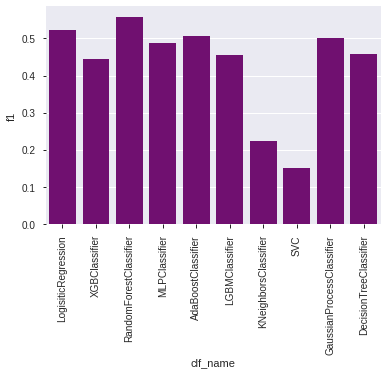

In [4]:
result = pd.DataFrame(columns=["clf_name", "pr", "rc", "f1", "auc", "acc"])
for i, (name, clf) in enumerate(classifiers.items()):
    y_pred = clf.steps[-1][1].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    result.loc[i] = [name, pr, rc, f1, auc, acc]
    
print(result)
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

### first elimination

The test set result comfirm our assumption about **SVC** and **KNeighborsClassifier** and show that **GaussianProcessClassifier** is also a bad predictor. Based on this result we will remove this two one.

In [4]:
del classifiers['SVC']
del classifiers['KNeighborsClassifier']
del classifiers['GaussianProcessClassifier']

### ROC
ROC is a probability curve and AUC represents degree or measure of separability

**We compute roc curve **

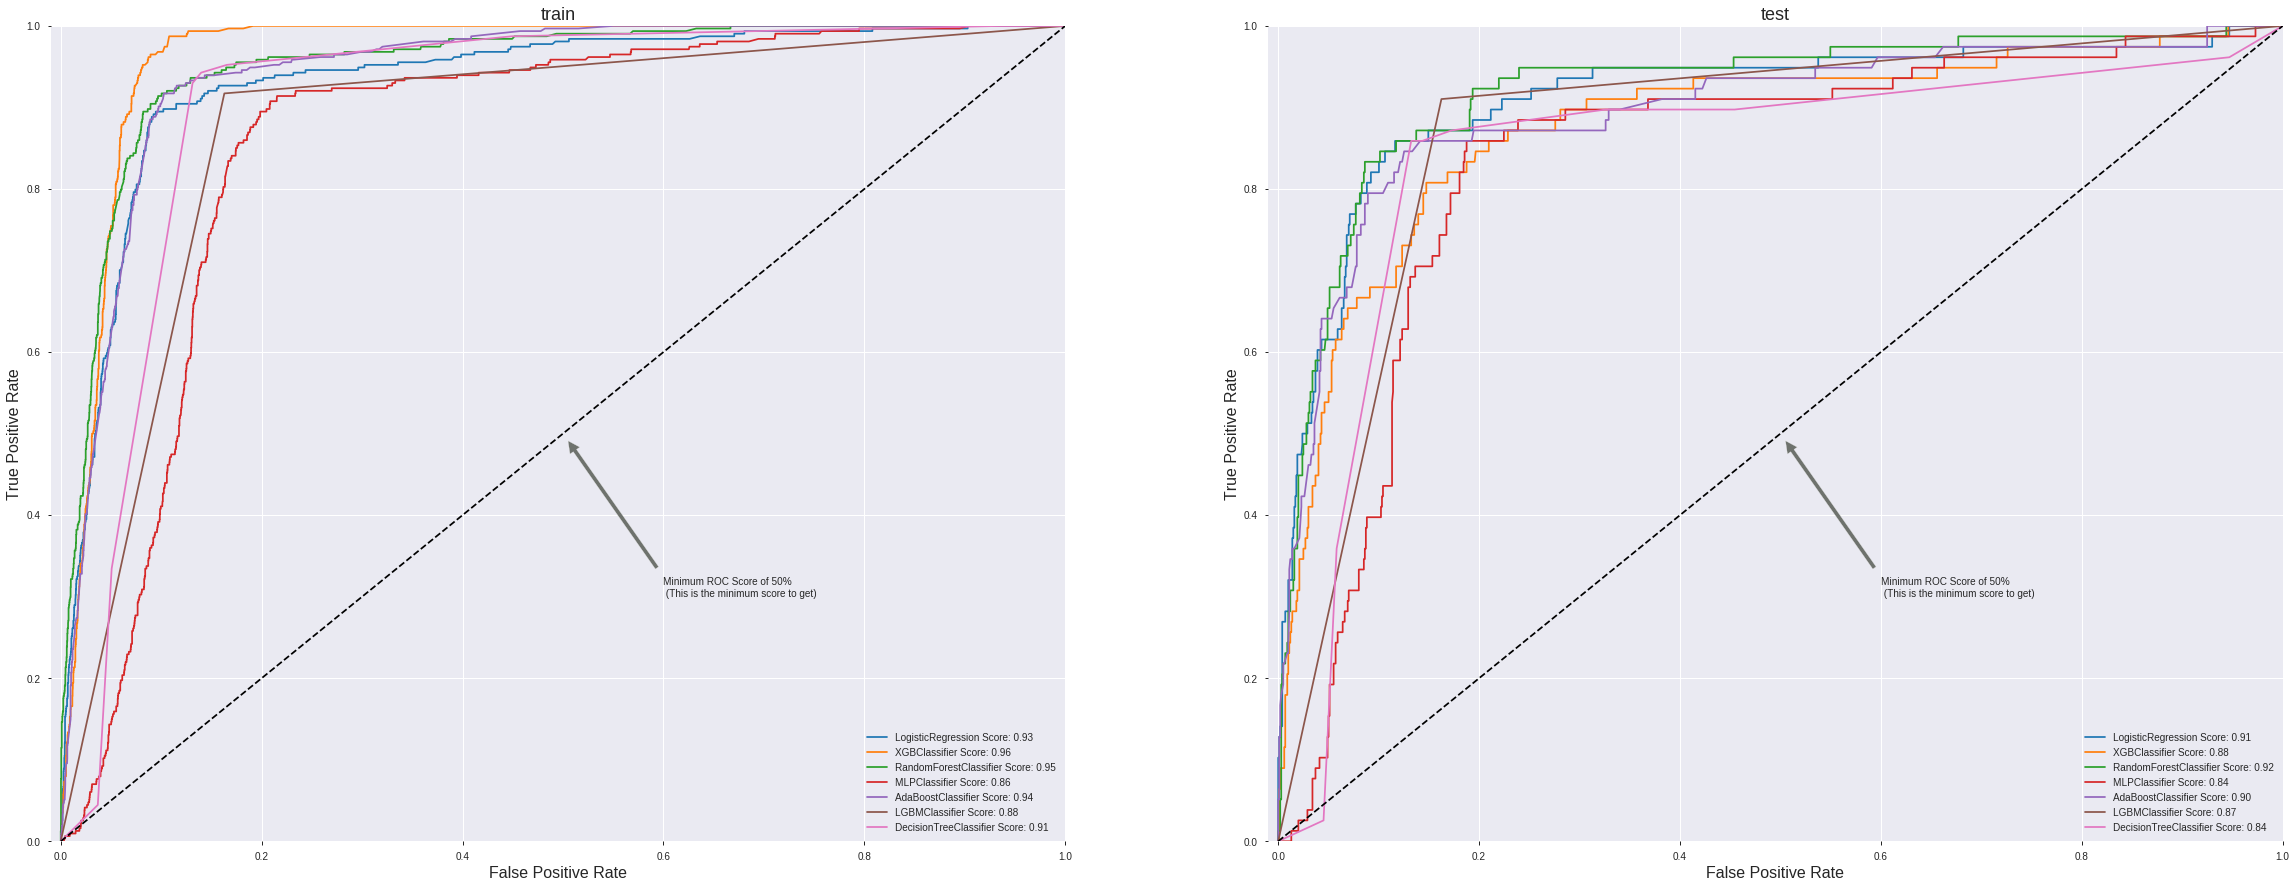

In [6]:
fig = plt.figure(1, figsize=(40, 15))
clf_without_sampling = {k:v.steps[-1][1] for k,v in classifiers.items()}

plt.subplot(1, 2, 1)
plot_roc_curve_multiple(clf_without_sampling, X_train, y_train, title = 'train', fig=fig)

plt.subplot(1, 2, 2)
plot_roc_curve_multiple(clf_without_sampling, X_test, y_test, title = 'test',  fig=fig)
plt.show()

# Model tuning

In [ ]:
Since models fail to have good precision scores . We optimize them according precision score .

In [9]:
tuned_params, tuned_estimator = tune_model(classifiers=tuned_estimator, X=X_train, y=y_train, scoring="precision")

Grid search for LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.3s finished


Grid search for XGBClassifier
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   24.7s finished


Grid search for RandomForestClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   48.6s finished


Grid search for MLPClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.7s finished


Grid search for AdaBoostClassifier
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   24.9s finished


Grid search for LGBMClassifier
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Grid search for DecisionTreeClassifier
Fitting 5 folds for each of 98 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:    1.4s finished


                 clf_name        pr        rc        f1       auc       acc
0      LogisticRegression  0.390533  0.846154  0.534413  0.871422  0.893023
1           XGBClassifier  0.364130  0.858974  0.511450  0.870811  0.880930
2  RandomForestClassifier  0.416667  0.833333  0.555556  0.871030  0.903256
3           MLPClassifier  0.281746  0.910256  0.430303  0.864356  0.825116
4      AdaBoostClassifier  0.382353  0.833333  0.524194  0.864009  0.890233
5          LGBMClassifier  0.304721  0.910256  0.456592  0.873884  0.842791
6  DecisionTreeClassifier  0.425806  0.846154  0.566524  0.878443  0.906047


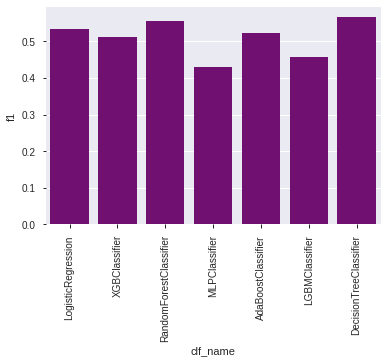

In [10]:
result = pd.DataFrame(columns=["clf_name", "pr", "rc", "f1", "auc", "acc"])
for i, (name, clf) in enumerate(tuned_estimator.items()):
    y_pred = clf.steps[-1][1].predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    result.loc[i] = [name, pr, rc, f1, auc, acc]
    
print(result)
g = sns.barplot(x="clf_name", y="f1", color="purple", data=result)
g.set_xticklabels(labels=g.get_xticklabels(),rotation=90)
plt.show()

We notice small f1-score improving due to increase of precision .

## Stacking models 

We are trying to have a strong predictor by stacking ours models .

In [16]:
y_stack = []
for i, (name, clf) in enumerate(tuned_estimator.items()):
    y_pred = clf.steps[-1][1].predict(X_test)
    y_stack.append(y_pred)
y_stack_pred = (np.mean(y_stack, axis=0)>0.5)*1

In [18]:
acc = accuracy_score(y_test, y_stack_pred)
pr = precision_score(y_test, y_stack_pred)
rc = recall_score(y_test, y_stack_pred)
f1 = f1_score(y_test, y_stack_pred)
auc = roc_auc_score(y_test, y_stack_pred)
pr, rc, f1, auc, acc

(0.4036144578313253,
 0.8589743589743589,
 0.5491803278688524,
 0.879838232646658,
 0.8976744186046511)

As you can see , stacking_model improve scores but it is not much better than logisticRegression